In [151]:
# Import libraries
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, SMOTENC

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint


import pickle
import matplotlib.pyplot as plt


## Load Dataset

In [152]:
df = pd.read_csv("bankloan.csv")
print(f"Dataset size: {df.shape}")
df = df.dropna(thresh=2)
df.tail()

Dataset size: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0.0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3.0,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1.0,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2.0,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0.0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


## Pre-Processing

In [153]:
# Define categorical columns for one-hot encoding
categorical_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

# Define numerical columns
numerical_features = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Define preprocessing for numerical features (imputation and scaling)
# numerical_transformer = SimpleImputer(strategy='median')  # Handle missing values
numerical_transformer = KNNImputer(n_neighbors=5)

# Define preprocessing for categorical features (imputation and one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # One-hot encoding
])

# Combine preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [154]:
# Apply the transformations
X = df.drop(columns=['Loan_ID', 'Loan_Status'])  # Drop columns not used in modeling
y = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Fit and transform the data
X_transformed = preprocessor.fit_transform(X)

# Display the transformed data
# Convert the transformed data to a DataFrame for better readability
feature_names = (
    numerical_features +
    preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()
)
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
X_transformed_df

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0.0,5849.0,0.0,147.8,360.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,4583.0,1508.0,128.0,360.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,3000.0,0.0,66.0,360.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,2583.0,2358.0,120.0,360.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,6000.0,0.0,141.0,360.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,2900.0,0.0,71.0,360.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
610,3.0,4106.0,0.0,40.0,180.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
611,1.0,8072.0,240.0,253.0,360.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
612,2.0,7583.0,0.0,187.0,360.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


## Dataset Imbalance

In [155]:
df["Loan_Status"].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

## Balance Dataset

In [156]:
smote = SMOTE(sampling_strategy="minority")
X, y = smote.fit_resample(X_transformed, y)
print(f"Balanced Dataset: {dict(Counter(y))}")

Balanced Dataset: {1: 422, 0: 422}


In [157]:
scaler = MinMaxScaler() # Feature scaling
X = scaler.fit_transform(X)
# Display the transformed data
# Convert the transformed data to a DataFrame for better readability
feature_names = (
    numerical_features +
    preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()
)
X_df = pd.DataFrame(X, columns=feature_names)
X_df

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0.000000,0.070489,0.000000,0.200868,0.743590,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,0.000000,1.000000
1,0.333333,0.054830,0.036192,0.172214,0.743590,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,0.0,1.000000,0.000000,0.000000
2,0.000000,0.035250,0.000000,0.082489,0.743590,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.0,1.0,0.000000,0.000000,1.000000
3,0.000000,0.030093,0.056592,0.160637,0.743590,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.0,0.0,0.000000,0.000000,1.000000
4,0.000000,0.072356,0.000000,0.191027,0.743590,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,0.000000,0.017761,0.040243,0.134897,0.736869,0.000000,0.737898,0.262102,0.737898,0.262102,1.000000,0.000000,1.0,0.0,0.000000,0.737898,0.262102
840,0.000000,0.026359,0.000000,0.066050,0.743590,0.382823,0.382823,0.617177,0.382823,0.617177,1.000000,0.000000,1.0,0.0,0.382823,0.000000,0.617177
841,0.000000,0.080904,0.104995,0.313134,0.743590,0.165409,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1.000000,0.000000,0.000000
842,0.728079,0.021031,0.000000,0.082794,0.743590,0.244729,0.592118,0.407882,0.592118,0.407882,0.407882,0.592118,1.0,0.0,0.407882,0.000000,0.592118


## Test Train Split

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)


# Model

In [159]:
classifier = Sequential()
classifier.add(Dense(100, activation='relu', kernel_initializer='LecunNormal', input_dim=X_test.shape[1]))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))
classifier.add(Dense(200, activation='relu', kernel_initializer='LecunNormal'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))
classifier.add(Dense(20, activation='relu', kernel_initializer='LecunNormal'))
classifier.add(BatchNormalization())
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='LecunNormal'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = classifier.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=50, epochs=100, verbose=0)
print(f"Training: {classifier.evaluate(X_train, y_train)}")
print(f"Test: {classifier.evaluate(X_test, y_test)}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8869 - loss: 0.2905 
Training: [0.29747581481933594, 0.8740741014480591]
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.8313 - loss: 0.4837  
Test: [0.4725932776927948, 0.8106508851051331]


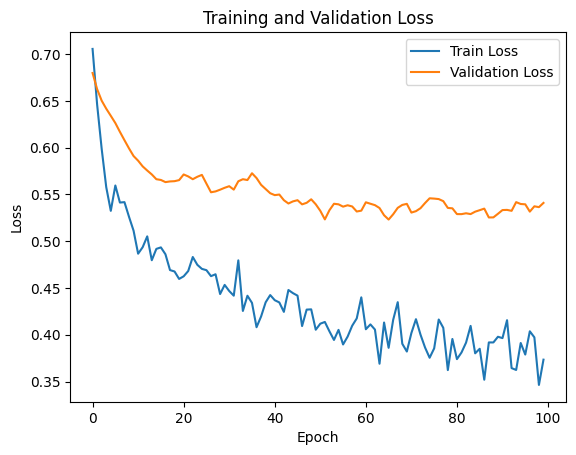

In [160]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Confusion Matrix

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


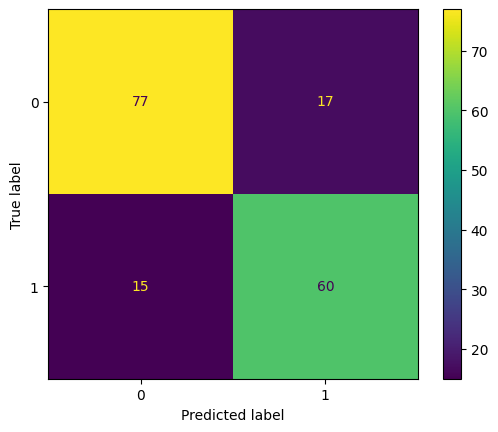

In [161]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

## Create Pipeline

In [162]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('PreProcessor', preprocessor),
    ('Scaler', MinMaxScaler()),
    ('model', KerasClassifier(classifier))
])

In [163]:
X, y = df.drop(columns=["Loan_Status"]), df["Loan_Status"]

In [164]:
X.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [165]:
X["LoanAmount"].max()

700.0

In [166]:
pipeline.fit(X, y)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6993 - loss: 0.6623


Pipeline(steps=[('PreProcessor',
                 ColumnTransformer(transformers=[('num', KNNImputer(),
                                                  ['Dependents',
                                                   'ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Married',
                                                   'Education', 'Self_Employed',
                                                   'Property_Area'])])),
                ('Scaler', MinMaxScaler()),
                ('model',
                 KerasClassifier(model=<Sequential name=sequential_17, built=True>))])

In [167]:
pipeline.score(X, y)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.8208469055374593

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


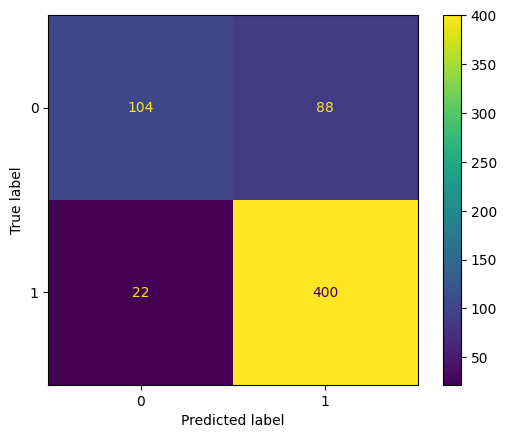

In [168]:
y_pred = pipeline.predict(X)

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Save pipeline

In [169]:
filename = "loan_model.pkl"
pickle.dump(pipeline, open(filename, 'wb'))